In [1]:
import utils

In [2]:
import json
import os

MAP = "corner"

dwa = utils.load_data(os.path.abspath("dumped_data"), MAP, "dwa")
tr = utils.load_data(os.path.abspath("dumped_data"), MAP, "tr")
teb = utils.load_data(os.path.abspath("dumped_data"), MAP, "teb")
mpc = utils.load_data(os.path.abspath("dumped_data"), MAP, "mpc")

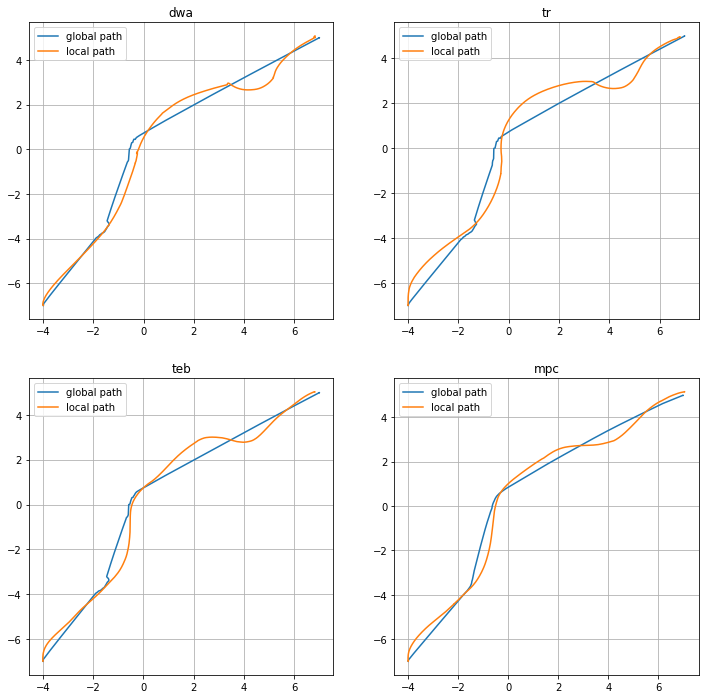

In [3]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(12, 12))

for i, approach in enumerate([dwa, tr, teb, mpc]):
    ax = axs[i//2][i%2]
    ax.grid(True, "both")
    ax.plot(approach.global_path.x, approach.global_path.y, label="global path")
    ax.plot(approach.local_path.x, approach.local_path.y, label="local path")
    ax.title.set_text(approach.approach_name)
    ax.legend()

plt.show()


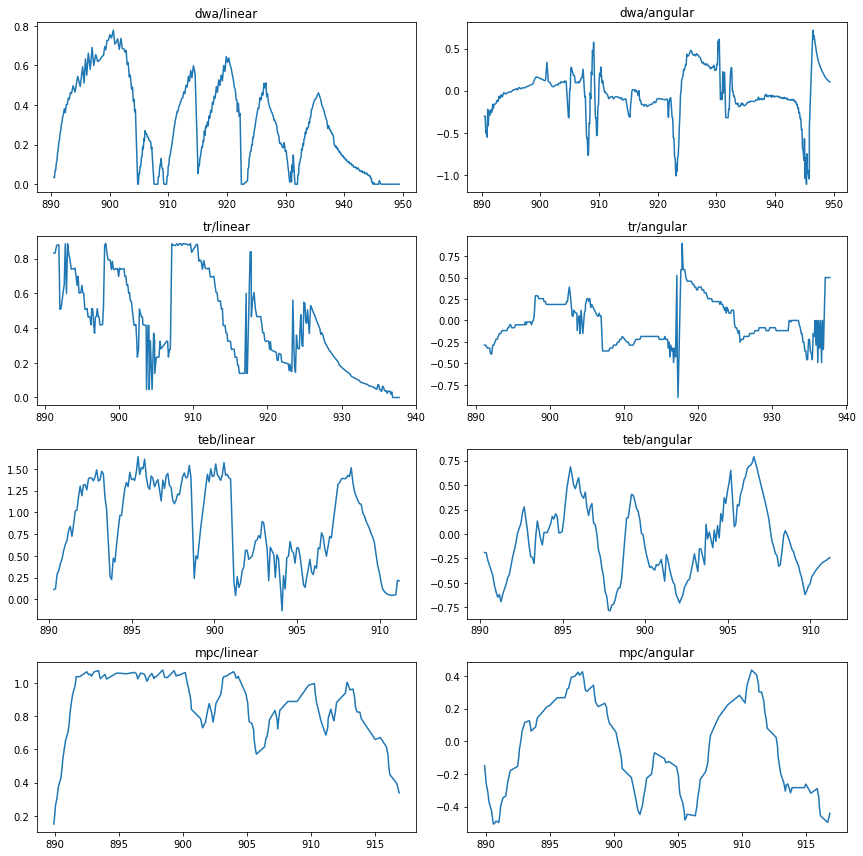

In [4]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 2, figsize=(12, 12))

map(lambda ax: ax.grid(True, "both"), [ax for sublist in axs for ax in sublist])

for i, approach in enumerate([dwa, tr, teb, mpc]):
    axs[i][0].plot(approach.velocity.t, approach.velocity.linear)
    axs[i][1].plot(approach.velocity.t, approach.velocity.angular)
    axs[i][0].title.set_text(f"{approach.approach_name}/linear")
    axs[i][1].title.set_text(f"{approach.approach_name}/angular")

fig.tight_layout()
plt.show()

#### Гладкость скоростей

In [5]:
import pandas as pd

smoothness = {a.approach_name: {"linear": 0, "angular": 0} for a in [dwa, tr, teb, mpc]}
for a, t in [(a, t) for a in [dwa, tr, teb, mpc] for t in ["linear", "angular"]]:
    smoothness[a.approach_name][t] = utils.evaluate_smoothness(a.velocity, "t", t, angle_fix=t=="angular")

smoothness = pd.DataFrame(smoothness).T
smoothness["common"] = smoothness.linear + smoothness.angular
smoothness.round(3)

,linear,angular,common
dwa,17.327,30.627,47.955
tr,76.043,40.786,116.829
teb,16.464,13.241,29.705
mpc,13.516,14.476,27.992


#### Гладкость пути

In [6]:

{a.approach_name: utils.evaluate_smoothness(a.local_path, "t", "x", "y") for a in [dwa, tr, teb, mpc]}

{'dwa': 1.1916799028113816,
 'tr': 1.2042844333006772,
 'teb': 1.1316646525477705,
 'mpc': 1.0392217436225846}

#### Отклонение от маршрута

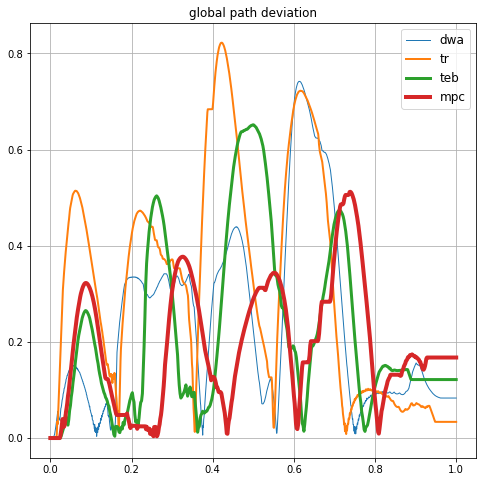

In [7]:
normalize = lambda data: (data - data.min())/(data.max() - data.min())

plt.figure(figsize=(8, 8))
plt.grid(True, "both")
plt.title("global path deviation")
for w, a in enumerate([dwa, tr, teb, mpc], start=1):
    plt.plot(
        normalize(a.global_path_deviation.t),
        a.global_path_deviation.dist,
        linewidth=w, label=f"{a.approach_name}"
    )
plt.legend(fontsize="large")
plt.show()


In [8]:
pd.DataFrame(
    {a.approach_name: a.measured_deviation.__dict__ for a in [dwa, tr, teb,mpc]}
)

,dwa,tr,teb,mpc
absolute,14.619418,15.648336,5.359373,5.799646
relative,0.819247,0.859155,0.302746,0.326488


In [9]:
{a.approach_name: a.travel_time for a in [dwa, tr, teb, mpc]}

{'dwa': 58.831999999999994,
 'tr': 46.575000000000045,
 'teb': 20.89300000000003,
 'mpc': 26.997999999999934}

In [10]:
{a.approach_name: a.freq for a in [dwa, tr, teb, mpc]}


{'dwa': 9.523809523807873,
 'tr': 7.874015748034428,
 'teb': 9.999999999997726,
 'mpc': 8.547008547007184}

In [11]:
summary = pd.DataFrame({a.approach_name: {
    "route_smoothness": utils.evaluate_smoothness(a.local_path, "t", "x", "y"),
    "velocity_smoothness": utils.evaluate_smoothness(a.velocity, "t", "linear") + utils.evaluate_smoothness(a.odom_velocity, "t", "angular"),
    "avg_velocity": a.velocity.linear.mean(),
    "max_velocity": a.velocity.linear.max(),
    "route_deviation": a.measured_deviation.relative,
    "travel_time": a.travel_time,
    "freq_time": a.freq,
} for a in [dwa, tr, teb, mpc]}).T

summary.round(4)

,route_smoothness,velocity_smoothness,avg_velocity,max_velocity,route_deviation,travel_time,freq_time
dwa,1.1917,60.7445,0.2402,0.7787,0.8192,58.832,9.5238
tr,1.2043,120.2568,0.4029,0.8873,0.8592,46.575,7.8740
teb,1.1317,38.2347,0.8849,1.6392,0.3027,20.893,10.0000
mpc,1.0392,47.6574,0.8597,1.0779,0.3265,26.998,8.5470


In [12]:
norm_summary = summary.copy()
norm_summary.route_smoothness = 1 / (summary.route_smoothness / summary.route_smoothness.min())
norm_summary.velocity_smoothness = 1 / (summary.velocity_smoothness / summary.velocity_smoothness.min())
norm_summary.route_deviation = 1 / (summary.route_deviation / summary.route_deviation.min())
norm_summary.travel_time = 1 / (summary.travel_time / summary.travel_time.min())
norm_summary.avg_velocity = summary.avg_velocity / summary.avg_velocity.max()
norm_summary.max_velocity = summary.max_velocity / summary.max_velocity.max()
norm_summary.freq_time = summary.freq_time / summary.freq_time.max()
norm_summary["grade"] = norm_summary.apply(sum, axis=1)
norm_summary.round(4)

,route_smoothness,velocity_smoothness,avg_velocity,max_velocity,route_deviation,travel_time,freq_time,grade
dwa,0.8721,0.6294,0.2715,0.4750,0.3695,0.3551,0.9524,3.9251
tr,0.8629,0.3179,0.4553,0.5413,0.3524,0.4486,0.7874,3.7658
teb,0.9183,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,6.9183
mpc,1.0000,0.8023,0.9715,0.6576,0.9273,0.7739,0.8547,5.9872
